In [39]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(tidymodels)
library(scales)
options(repr.matrix.max.rows = 6)

# Project Final Report #
- By: Megan, Tiffany, and Denny

# 1. Introduction #

* insert text here *

# 2. Methods and Results #

In this analysis, we are trying to predict the subscription status of players based on these two quantitative predictor values: Age and played_hours on PLAIcraft using the players.cv dataset. Thus, we need to train a k-nearest neighbors classification model in order to observe the relationship of the scattered data. To further validate and train the classification model on data it has never processed before, we will split the data into a training set and testing set to perform a 5 v-fold cross validation set and tune the model to find the most accurate k value. Throughout this evaluation, we will also assess the accuracy, precision, and recall to further synthesize the functionality of our classification model. 

In [40]:
players <- read_csv("https://raw.githubusercontent.com/tiffyue/dsci_100_project/refs/heads/main/data/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


We will wrangle the players.csv dataset by mutating subscribe as a factor since it is our target variable in this classification model. Also, we must filter all the NA characters in Age to make sure all the columns are in double type. Then, a summary analysis is performed to attain the mean of played_hours and Age to discern the average demographic of the collected data. An exploratory preview is also included to give a general idea of the subscription status.

In [41]:
# Wrangling dataset to compensate for missing observations in Age
players_data <- players |> 
    mutate(subscribe = as_factor(subscribe)) |>
    filter(!is.na(Age)) |>
    select(subscribe, played_hours, Age)


# mean of all the quantitative data (played_hours and Age)

mean_players <- players_data |>
    mutate(mean_played_hours = mean(played_hours), 
           mean_Age = mean(Age)) |>
    select(mean_played_hours, mean_Age) |>
    slice(1)
    
    
players_data
mean_players

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
⋮,⋮,⋮
FALSE,0.3,22
FALSE,0.0,17
FALSE,2.3,17


mean_played_hours,mean_Age
<dbl>,<dbl>
5.904639,20.52062


| Quantitative Player Data  | Mean
|--------------|-----
| played_hours | 5.90
| Age          | 20.5

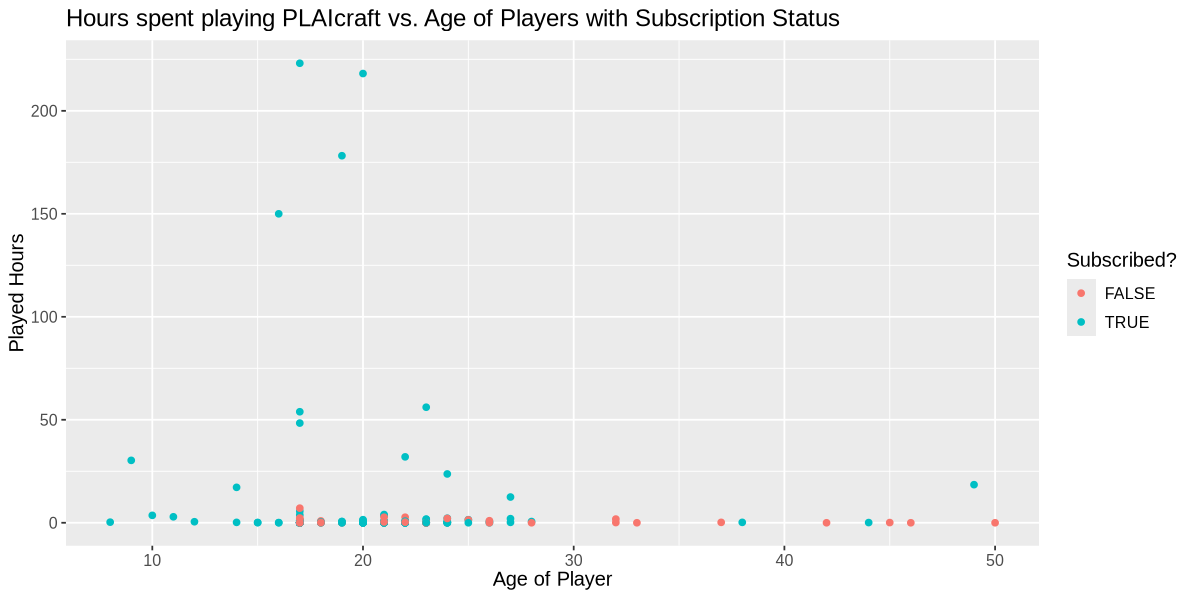

In [42]:
set.seed(50)
# exploratory preview to the players_data dataset

options(repr.plot.height = 5, repr.plot.width = 10)
players_data_plot <- players_data |>
                    ggplot(aes(x = Age, y = played_hours,
                              color = subscribe)) +
                    geom_point() + 
                    labs(x = "Age of Player",
                         y = "Played Hours",
                         color = "Subscribed?") +
                    ggtitle("Hours spent playing PLAIcraft vs. Age of Players with Subscription Status") +
                    theme(text = element_text(size = 12))

                         
players_data_plot

Next, we will make sure that a seed is set to an arbitrary number (50) so the split is reproducible for the following data analysis. The wrangled dataset players_data will be used and the proportion of the split is 75% training and 25% since we want more examples for the training set to attain pattern recognition which increases the overall accuracy. The strata argument will be subscribe since that is the target variable we want to predict. 

In [43]:
set.seed(50)
# splitting the data into training and test datasets 
# 75% is training data, 25% is test data 

players_split <- initial_split(players_data, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

We will double check if the split had been carried out and is similar to our intended proportion.

In [44]:
set.seed(50)
# double check the split of the proportions 

players_proportion <- players_train |>
                      group_by(subscribe) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(players_train))

players_proportion

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,39,26.89655
TRUE,106,73.10345


Moving on, will will begin the 5 v-fold knn classification training process by creating a workflow with specifications in the recipe and specs where the tune() function indicates that we are trying to extract the most accurate k value from 1 - 100 by 5 in the k_vals dataframe. Scaling and centering is also needed since either the quantitative values of played_hours or Age could be overrepresented in the euclidean distance measuring. Then, the 5 v-fold dataframe is fitted in the workflow using tune_grid() alongside collect_metrics() to aggregate the mean and standard error. Finally, we can filter the evaluation by "accuracy" to visualize the most accurate k-value.  

In [45]:
set.seed(50)

# we need to standardize and center the quantitative data using a recipe 

players_recipe <- recipe(subscribe ~., data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# create the 5 fold cross validation  
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

# use values from 1 to 100 by 5 

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

# fit the knn model 
knn_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = players_vfold, grid = k_vals) |>
  collect_metrics()

# indicate the accuracy (mean) and its standard error
accuracies <- knn_fit |>
  filter(.metric == "accuracy") 

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4877504,5,0.05242820,Preprocessor1_Model01
6,accuracy,binary,0.5645813,5,0.03831680,Preprocessor1_Model02
11,accuracy,binary,0.6395238,5,0.06346711,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
86,accuracy,binary,0.7311494,5,0.005037841,Preprocessor1_Model18
91,accuracy,binary,0.7311494,5,0.005037841,Preprocessor1_Model19
96,accuracy,binary,0.7311494,5,0.005037841,Preprocessor1_Model20


We will visualize the ggplot using geom_point() and geom_line() for mean vs. neighbors in the accuracies dataframe. To pick the most accurate k-value, it must demonstrate a peak in which is the greatest amount of accuracy we can pull from the analysis.  

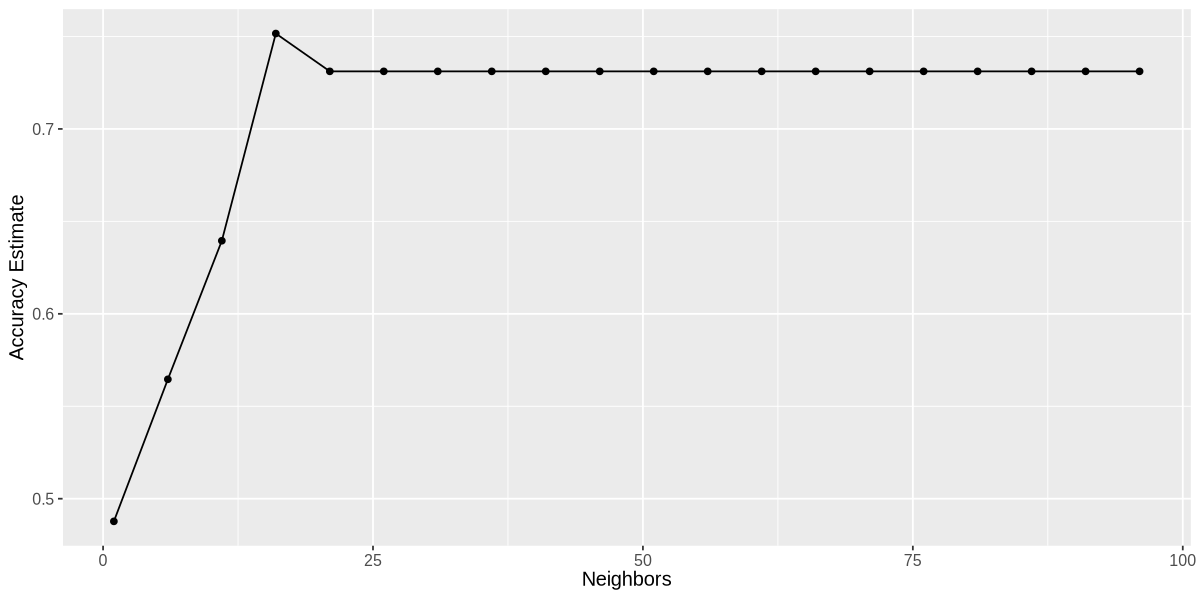

In [46]:
set.seed(50)
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

It looks like the value is around ~ 15 - 20. Let's use the arrange function to attain the highest accuracy value when the data frame is in descending order (largest -> smallest). 

In [47]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 16

Now that we know that 16 is our best k-value, we will refit the training data with the best_k into the workflow for the knn classification model: 

In [48]:
set.seed(50)
# calculate the new fit with the best k 

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_train)

players_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(16,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2551724
Best kernel: rectangular
Best k: 16

Next, we can finally predict the target variable __subscribe__ in the test data and compare the accuracy to our training data classification:

In [49]:
set.seed(50)
# predict with the test data 
players_test_predictions <- predict(players_fit, players_test) |>
  bind_cols(players_test)

players_test_predictions

.pred_class,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
TRUE,FALSE,0,17
TRUE,TRUE,0,17
TRUE,TRUE,0,17
⋮,⋮,⋮,⋮
TRUE,FALSE,1.7,17
FALSE,TRUE,0.1,44
TRUE,FALSE,0.0,17


To better understand the accuracy of all the observations, we will use the function metrics() to compute the performance score. "Truth" will be the subscribe column for all the metric calculations as that is our target variable. All of the estimates are .pred_class since we want to assess the sorting capabilities of the model for the classification of the target value. Accuracy tells us the ratio of how many times the classifier produced a correct prediction for the target variable subscribe is 69.3%

In [50]:
set.seed(50)
# evaluate the performance of accuracy
players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6938776


Next, we will check the levels of the order in the subscribe column to help us define the event level for precision() and recall(). The observation that is most significant is TRUE since we want to find out what parameters of Age and played_hours to target in increasing the subscription status. This will be our "positive" value later on when we work on the confusion matrix. 

In [51]:
set.seed(50)
# check the order of subscribe 
players_test_predictions |> pull(subscribe) |> levels()

[1] "FALSE" "TRUE"

Since TRUE is the second observation, we will set the event_level to "second" for the precision and the recall calculations. The precision calculation will further assess how many of the positive predictions (subscribe) were actually positive. Thus, we attain a precision value of 74.4%

In [52]:
set.seed(50)
# evaluate the precision 
players_test_predictions |>
  precision(truth = subscribe, estimate = .pred_class, event_level = "second")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.744186


Finally, we will evaluate the recall which is the most important metric for our analysis in making sure that the positive observations in subscribe (TRUE) were identified as positive to have greater confidence in our classification model. The recall that we attained is 88.9%. 

In [53]:
set.seed(50)
# evaluate the recall 
players_test_predictions |>
  recall(truth = subscribe, estimate = .pred_class, event_level = "second")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.8888889


To further examine the accuracy in classifying players as subscribed or not, we can make a confusion matrix to compare and model the correct and incorrect predictions of predicted labels that affects precision and recall where TRUE is positive and FALSE is negative. 

In [54]:
set.seed(50)
# create a confusion matrix to evaluate positives (TRUE) and negative (FALSE) 
confusion <- players_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion

          Truth
Prediction FALSE TRUE
     FALSE     2    4
     TRUE     11   32

9 observations were correctly predicted as false (true negative)  and 20 observations were correctly predicted as true (true positive) out of the 24 observations. 4 observations were assigned as true when they are actually false (false positive) while 16 observations were assigned as false when they are actually true (false negative). 


Lastly, we can model the players_test_predicitons data frame using a scatter plot where x is the Age of Player and Y is the Played hours, with the subscription status indicated on the legend. It is then faceted by subscription status to better observe the distribution of the predictions and how the model assigns the class groupings. 

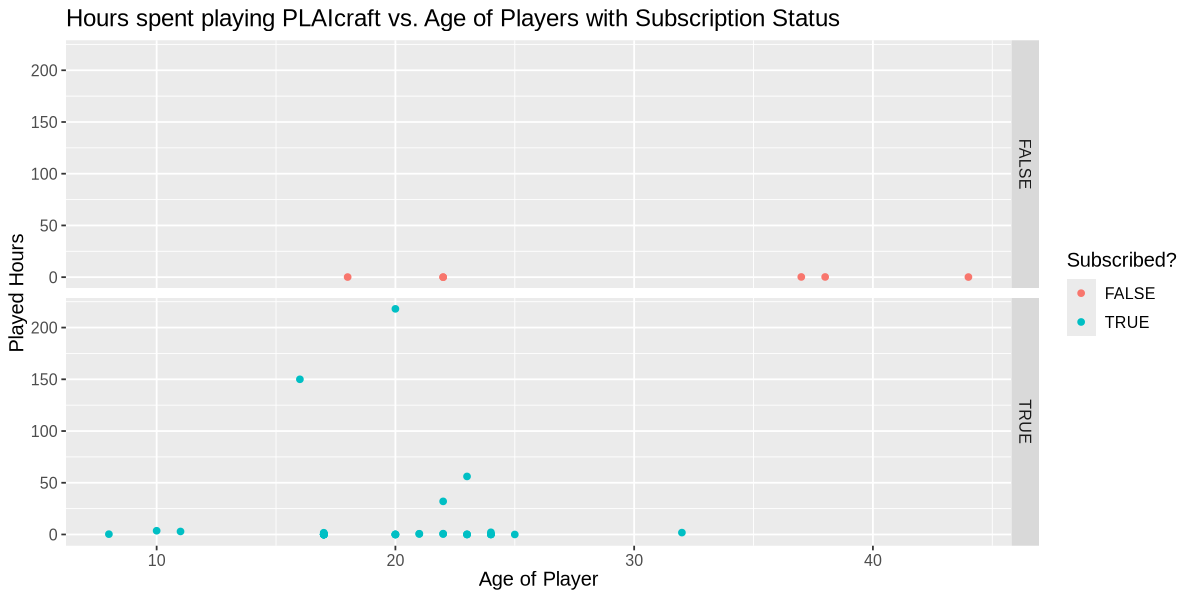

In [55]:
set.seed(50)
# scatterplot of played_hours vs Age when evaluating .pred class (TRUE or FALSE)
options(repr.plot.height = 5, repr.plot.width = 10)
subscribe_plot <- players_test_predictions |>
                    ggplot(aes(x = Age, y = played_hours,
                              color = .pred_class)) +
                    geom_point() + 
                    labs(x = "Age of Player",
                         y = "Played Hours",
                         color = "Subscribed?") +
                    ggtitle("Hours spent playing PLAIcraft vs. Age of Players with Subscription Status") +
                    facet_grid(rows = vars(.pred_class))+
                    theme(text = element_text(size = 12))

                         
subscribe_plot

# 3. Discussion #

* Insert text here *